# LightGBM 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/classweight_submission_Logistic4.csv
../data/ozon_4_.ipynb
../data/sample_submit.csv
../data/smoto_submission_ensemble.csv
../data/smoto_submission_lightBGM.csv
../data/smoto_submission_Logistic.csv
../data/submission_ensemble.csv
../data/submission_lightBGM.csv
../data/submission_lightBGM2.csv
../data/submission_lightBGM2_2.csv
../data/submission_lightBGM3.csv
../data/submission_Logistic.csv
../data/submission_Logistic2.csv
../data/submission_Logistic3.csv
../data/sumoto_submission_Logistic2.csv
../data/sumoto_submission_Logistic3.csv
../data/sumoto_submission_Logistic3_2.csv
../data/sumoto_submission_Logistic3_3.csv
../data/sumoto_submission_Logistic4.csv
../data/sumoto_submission_Logistic4_2.csv
../data/test.tsv
../data/train.tsv
../data/.ipynb_checkpoints\ozon_4_-checkpoint.ipynb
../data/.ipynb_checkpoints\sample_submit-checkpoint.csv
../data/.ipynb_checkpoints\submission_ensemble-checkpoint.csv
../data/.ipynb_checkpoints\submission_lightBGM-checkpoint.csv
../data/.ipynb_ch

In [20]:
train_df = pd.read_table('../data/train.tsv', index_col='Date', parse_dates=True)
test_df = pd.read_table('../data/test.tsv', index_col='Date', parse_dates=True)
sample_sub = pd.read_csv('../data/sample_submit.csv')
print(sample_sub)

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

# all data
all_df = pd.concat([train_df, test_df], axis=0)

      1267  0.0
0     1268  0.0
1     1269  0.0
2     1270  1.0
3     1271  1.0
4     1272  1.0
...    ...  ...
1261  2529  1.0
1262  2530  1.0
1263  2531  0.0
1264  2532  1.0
1265  2533  0.0

[1266 rows x 2 columns]


## 特徴量前処理

In [21]:
import re
from imblearn.over_sampling import SMOTE


def eda(all_df):
    # データの追加,気温・風速の標準偏差
    #1時間ごとの気温・風速を取得
    T_data = all_df[['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23']]
    WSR_data = all_df[['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23']]
    # 行ごとの標準偏差を追加
    all_df['T_SD'] = T_data.std(axis=1)
    all_df['WSR_SD'] = WSR_data.std(axis=1)
    """
    # データの削除, T0~T23
    all_df = all_df.drop(columns=['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23'])
    # データの削除, WSR0~WSR23
    all_df = all_df.drop(columns=['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23'])
    """
    # データの削除, SLP_
    all_df = all_df.drop(columns=['SLP_'])
    return all_df


# 特徴量の削除/追加
all_df = eda(all_df)

# trainとtestに分けなおす
train_df = all_df[all_df['type'] == 'train']
test_df = all_df[all_df['type'] == 'test']
# train正解ラベル
y = train_df['OZONE']

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['id', 'OZONE', 'type'])
test_df = test_df.drop(columns=['id', 'OZONE', 'type'])

# 欠損値を平均値で補完
train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())

# オーバーサンプリング
# SMOTEの初期化と適用
smote = SMOTE(random_state=42)
train_df, y = smote.fit_resample(train_df, y)

"""
# データ標準化(rightGBMのときはいらない)
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), index = train_df.index, columns = train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index = test_df.index, columns = test_df.columns)
"""
print(y)
# print(f'train_df : \n{train_df}\n')
# print(f'y : \n{y}\n')

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2307    1.0
2308    1.0
2309    1.0
2310    1.0
2311    1.0
Name: OZONE, Length: 2312, dtype: float64


### LightGBM

In [22]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

#khold
cv = KFold(n_splits=5, random_state=0, shuffle=True)

train_acc_list = []
val_acc_list = []
models = []
lgb_results = {}   # 学習の履歴を入れる入物

# ハイパーパラメータを定義　
lgb_params = {
    "objective":"binary",      #目的：二値分類
    # "metric": "binary_error",  #評価指標 : 不正解率(1 - 正解率)
    "metric": "binary_logloss",
    "force_row_wise" : True,
    "seed" : 0,
    'learning_rate': 0.07,
    'min_data_in_leaf': 5,
    # "reg_lambda": .1,
     # "reg_alpha": .1,
    "early_stopping_rounds": 50,
    "verbose_eval": 200,
    "max_depth": 5, 
    "min_child_samples": 20,
    }

# indexをDateから普通のindexに直す(kholdが使えないため)、日付は消す
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# KFold で学習させる
for i ,(trn_index, val_index) in enumerate(cv.split(train_df, y)):
    
    print(f'Fold : {i}')
    X_train ,X_val = train_df.loc[trn_index], train_df.loc[val_index]
    y_train ,y_val = y[trn_index],y[val_index]
    
    # LigthGBM用のデータセットを定義
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_val, y_val)
    
    model = lgb.train(
        params = lgb_params,         # ハイパーパラメータをセット
        train_set = lgb_train,       # 訓練データを訓練用にセット
        valid_sets = [lgb_train, lgb_valid],   # 訓練データとテストデータをセット
        valid_names=['Train', 'Valid'],    # データセットの名前をそれぞれ設定
        callbacks=[lgb.log_evaluation(period=100),lgb.early_stopping(10), lgb.record_evaluation(lgb_results)], # アウトプット
    )
    
    y_pred = model.predict(X_train)
    print(f'y_pred.sum------------------------{np.where(y_pred>=0.5, 1, 0).sum()}')
    print(f'y_train.sum----------------------{y_train.sum()}')
    
    train_acc = balanced_accuracy_score(
        y_train, np.where(y_pred>=0.5, 1, 0)
        )
    print(train_acc)
    train_acc_list.append(train_acc)
    
    y_pred_val = model.predict(X_val)
    val_acc = balanced_accuracy_score(
        y_val, np.where(y_pred_val>=0.5, 1, 0)
        )
    print(val_acc)
    val_acc_list.append(val_acc)
    
    models.append(model)

print('-'*10 + 'Result' +'-'*10)
print(f'Train_acc : {train_acc_list} , Ave : {np.mean(train_acc_list)}')
print(f'Valid_acc : {val_acc_list} , Ave : {np.mean(val_acc_list)}')

Fold : 0
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 941, number of negative: 908
[LightGBM] [Info] Total Bins 18410
[LightGBM] [Info] Number of data points in the train set: 1849, number of used features: 73
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warnin

### 学習履歴の表示

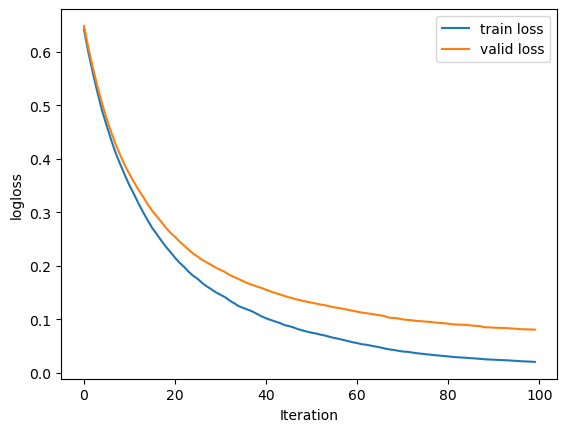

In [23]:
loss_train = lgb_results['Train']['binary_logloss']
loss_valid = lgb_results['Valid']['binary_logloss']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_valid, label='valid loss')
 
plt.legend()
plt.show()

→過学習？

In [25]:
# モデルを用いてテストデータを予測
test_pred = np.zeros((len(test_df), 5))
for fold_index , gbm in enumerate(models):
    pred_test = gbm.predict(test_df)
    print(np.where(pred_test>=0.5, 1, 0).sum())
    # test_pred[:, fold_index] = pred_test
    test_pred[:, fold_index] = np.where(pred_test>=0.5, 1, 0)

# 行数で繰り返し予測値を代入
test_pred = pd.DataFrame(test_pred)
test_pred = test_pred.mode(axis=1).values
print(f'test_pred.sum : {test_pred.sum()}')
for index, row in sample_sub.iterrows():
    sample_sub.iloc[index,1] = test_pred[index]
    
# 結果を保存
sample_sub.to_csv("../data/sumote_submission_lightBGM_0516.csv", index=False)

96
82
93
106
87
test_pred.sum : 91.0
